<p style="font-size:30px; text-align:center"><b>Gaussian Process Regression</b></p>
<div style="text-align: right">(C) Nikolai Nowaczyk, <a href="https://github.com/Lapsilago">Jörg Kienitz</a> 2021</div>

Gaussian process regression (GPR) is a powerful alternative to linear regression, which allows us to make predictions on a test data set $X^*$ given some labelled training data set $(X,Y)$. A big advantage is that we do not only obtain the predictions themselves, but also confidence regions around them. In this notebook we introduce Gaussian processes and how to use them for regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wdg

In [3]:
%matplotlib notebook

# uncomment to support dark themes
#plt.style.use(['dark_background'])

# Gaussian Processes
A key idea of Gaussian process regression is to think of an input data point $x_i$ not as a point, but as a mean of some distribution. Gaussian processes formalize that intution, which we introduce in this section and illustrate with an example.

## Definition

**Definition (Gaussian Process):** Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space, let $L^2(\Omega)$ denote the real-valued random variables on it and let $\mathcal{X}$ be any set. A *Gaussian Process* is a map $F:\mathcal{X} \times \Omega \to \mathbb{R}$ such that
* for any $x \in \mathcal{X}$, the map $F(x) := F(x, \_): \Omega \to \mathbb{R}$ is an $L^2$ random variable,
* for any finite number $n$ and any $X=(x_1, \ldots, x_n)$, $x_i \in \mathcal{X}$, the random variable $(F(x_1), \ldots, F(x_n))$ is multi-variate Gaussian on $\mathbb{R}^{n}$. 
The functions
\begin{align*}
    m: & \mathcal{X} \to \mathbb{R}, \quad x \mapsto \mathbb{E}[F(x)], \\
    k:& \mathcal{X} \times \mathcal{X} \to \mathbb{R}, \quad (x, x') \mapsto \operatorname{Cov}[F(x), F(x')] = \mathbb{E}[(F(x)-m(x))((F(y)-m(y)))]
\end{align*}
are called the associated *mean* respectively *covariance function*. We also write
\begin{align*}
    F \sim \mathcal{GP}(m, k).
\end{align*}

**Remarks**: 
* In most practical applications, the mean function is zero, i.e. $m \equiv 0$.
* The requirement that $F(x)$ is square integrable ensures that the covariance function is well-defined.
* In most practical applications, the set $\mathcal{X}$ is given by $\mathcal{X} = \mathbb{R}^d$. Thus, while $\mathcal{X} = \mathbb{R}_{\geq 0}$ is also a valid set, Gaussian processes are more general than stochastic processes as their parameter set $\mathcal{X}$ can be bigger. They are more special than stochastic processes due to the requirement of always beeing normally distributed.
* Analogously to stochastic processes, for any $\omega \in \Omega$, the map $F(\_, \omega): \mathcal{X} \to \mathbb{R}$ is called a *path*.
* By slight abuse of notation, for any vector $X=(x_1, \ldots, x_n)$, we set $F(X) = (F(x_1), \ldots, F(x_n))$.
* By slight abuse of notation, for any two vectors $X$, $X'$, we denote by $K(X,X') := (k(x_i, x'_k))_{ij}$ the evaluation of the covariance function on all the entries.

**Lemma:** The distribution of a Gaussian process is uniquely determined by its mean and its covariance function.

**Proof:** This simply follows from the fact that a Gaussian distribution is uniquely determined by its mean and its covariance.

## Example

We assume that $\mathcal{X}=\mathbb{R}$, $m\equiv 0$ and that
\begin{align*}
    k(x,x') := c^2 \exp(-\tfrac{1}{2 \ell}|x-x'|^2),
\end{align*}
for some $c, \ell \in \mathbb{R}$. For any given data $x^* = (x^*_1, \ldots, x^*_M)$, the resulting random variables are distributed as
\begin{align*}
    F(x^*) \sim \mathcal{N}(0, K(x^*, x^*)).
\end{align*}
We plot a few realizations below.

In [4]:
M = 20
num_paths=5
xs = np.linspace(0, 1, M)
Ks = np.array([np.array([10 * np.exp(-(x1-x2)**2/0.2) for x1 in xs]) for x2 in xs])
np.random.seed(1)
fs = np.random.multivariate_normal(mean=np.zeros(M), cov=Ks, size=num_paths)    

<IPython.core.display.Javascript object>


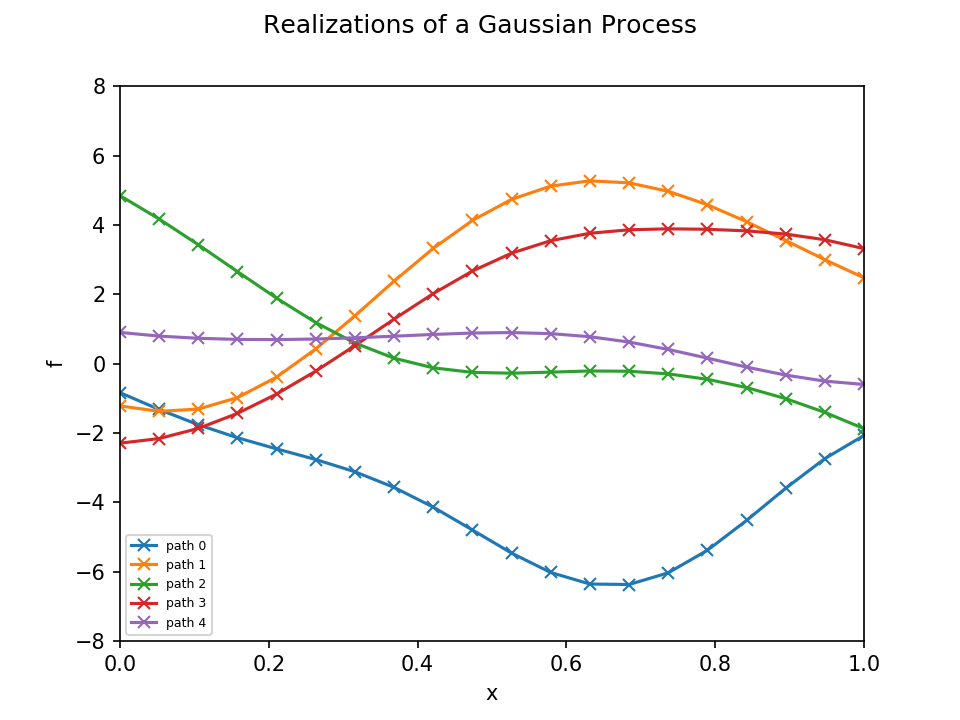

In [5]:
fig_gp_rel, ax_gp_rel = plt.subplots()
fig_gp_rel.suptitle('Realizations of a Gaussian Process')
ax_gp_rel.clear()
for path in range(num_paths):
    ax_gp_rel.plot(xs, fs[path], label='path %i' % path, marker='x')
ax_gp_rel.set_xlim([0, 1])
ax_gp_rel.set_ylim([-8, 8])
ax_gp_rel.set_xlabel('x')
ax_gp_rel.set_ylabel('f')
ax_gp_rel.legend(loc='lower left', prop={'size': 6})
plt.show()

# Gaussian Process Regression (GPR)

## Problem Formulation

In Gaussian processes can be used for regression as follows: We make the assumption that our training labels $y_i$ are related to the training data $x_i$ as possibly noisy observations of some unknown Gaussian process $F:\mathcal{X} \times \Omega \to \mathbb{R}$, $\mathcal{X}=\mathbb{R}^d$, $F \sim \mathcal{GP}(0, k)$ on some probability space $(\Omega, \mathcal{F}, \mathbb{P})$. We assume that there exist random variable $\varepsilon_i$ on $\Omega$, which are iid and Gaussian with zero mean and variance $\sigma^2$. We also assume that each $\varepsilon_i$ is independent from $F(x_i)$. Finally, we assume that our input data are a realization of that setup, i.e. there exists $\omega \in \Omega$ such that
\begin{align*}
    y_i = F(x_i, \omega) + \varepsilon_i(\omega)
\end{align*}
for all $i=1, \ldots, N$.

Technically, we assume that we are given the following inputs:
* traning data points $X = (x_1, \ldots, x_N)$, $x_i \in \mathbb{R}^d$,
* corresponding data labels $y = (y_1, \ldots, y_N)$, $y_i \in \mathbb{R}$,
* the covariance kernel function $k$ and the noise variance $\sigma^2$ (see [hyperparameter optimization](#sect_hyperparameter_optimization) for a discussion),
* test data points $x^* = (x^*_1, \ldots, x^*_M)$, $x_i^* \in \mathbb{R}^d$.

The $\omega$ and the noise $\varepsilon_i$ itself are not given as an input. The case $\sigma=0$, i.e. $\varepsilon_i \equiv 0$ is allowed and called *noise free*. 

What we want to produce as an ouput is:
* the conditional distribution of $F(X^*)$ given the input data.

## Theoretical Solution

At the heart of GPR lies the following theorem that describes the predictive distribution.

**Theorem (predictive distribution):** Let $F:\mathcal{X} \times \Omega \to \mathbb{R}$, $\mathcal{X} = \mathbb{R}^d$, be a Gaussian process with zero mean and covariance function $k:\mathcal{X} \times \mathcal{X} \to \mathbb{R}$. Let $X=(x_1, \ldots, x_N)$ be a set of training data, $y=(y_1, \ldots, y_N)$ be the corresponding labels and let $\varepsilon_i$ be Gaussian iid noise with zero mean and variance $\sigma^2$, which is independent of the $F(x_i)$ and set $\varepsilon:=(\varepsilon_1, \ldots, \varepsilon_N)$. Define $Y := F(X) + \varepsilon$. For any test data $X^* = (x^*_1, \ldots, x^*_M)$ the following hold: If $K(X, X) + \sigma^2 I$ is invertible, then the conditional distribution of $F(X^*)$ given $Y=y$ satisfies 
\begin{align*}
    F(X^*) \mid Y = y \sim \mathcal{N}(\bar m, \bar k),
\end{align*}
where
\begin{align*}
    m^* &:=  K(X, X^*) (K(X, X) + \sigma^2 I)^{-1} y\\
    k^* &:=  K(X^*, X^*) - K(X^*, X)(K(X,X) + \sigma^2 I)^{-1}K(X,X^*).
\end{align*}


**Proof:** By definition of a Gaussian Process, $F(X) \sim \mathcal{N}(0, K(X,X))$ and by assumption $\varepsilon \sim \mathcal{N}(0, \sigma^2 I)$. Therefore, $Y$ is Gaussian as well with mean zero and the independence assumptions imply
\begin{align*}
    \operatorname{Cov}[Y_i, Y_j] 
    = \operatorname{Cov}[F(x_i) + \varepsilon_i, F(x_j) + \varepsilon_j]
    =k(x_i, x_j) + \delta_{ij} \sigma ^2,
\end{align*}
thus, the covariance matrix of $Y$ is given by $K(X,X) + \sigma^2 I$. This implies that 
\begin{align*}
    \begin{pmatrix}
        Y \\
        F(X^*)
    \end{pmatrix} \sim \mathcal{N}\Big( 0, \begin{pmatrix}
        K(X,X) + \sigma^2 I & K(X, X^*) \\
        K(X^*, X) & K(X^*, X^*)
    \end{pmatrix} \Big)
\end{align*}
Now the claim follows from the [Gaussian conditioning theorem](#lem_cond_part_gaussian).

**Lemma (noise-free):** In case the input data is noise-free, i.e. $\sigma=0$, hence $\varepsilon \equiv 0$, the mean and covariance of the predictive disribution simplify to
\begin{align*}
    m^* &:=  K(X, X^*) K(X, X)f \\
    k^* &:=  K(X^*, X^*) - K(X^*, X)K(X,X)^{-1}K(X,X^*),
\end{align*}
where $f=(f_1, \ldots, f_N)$, $f_i := F(x_i, \omega) = y_i$.

## Practical Examples

Let us illustrate these theoretical results with some examples. We again use the Gaussian process from the previous example, i.e. we assume that $\mathcal{X}=\mathbb{R}$, $m\equiv 0$ and that
\begin{align*}
    k(x,x') := c^2 \exp(-\tfrac{1}{2 \ell^2}|x-x'|^2),
\end{align*}
for some $c, \ell \in \mathbb{R}$. The calculation of the conditional mean and covariance are easily performed as follows:

In [6]:
def gpr_pred(x_train, y_train, x_pred, cov_fun, sigma=0):
    k_xt_xt = np.matrix([[cov_fun(x1, x2) for x1 in x_train] for x2 in x_train]).T
    k_xt_xt += sigma**2 * np.diag(k_xt_xt[0])
    k_xt_xs = np.matrix([[cov_fun(x1, x2) for x1 in x_train] for x2 in x_pred]).T
    k_xs_xt = np.matrix([[cov_fun(x1, x2) for x1 in x_pred] for x2 in x_train]).T
    k_xs_xs = np.matrix([[cov_fun(x1, x2) for x1 in x_pred] for x2 in x_pred]).T
    m = k_xs_xt @ k_xt_xt.I @ y_train
    c = k_xs_xs - k_xs_xt @ k_xt_xt.I @ k_xt_xs
    return np.asarray(m).squeeze(), c

### Noise-free Case

It can be instructive to consider the easier noise-free case first, so let us also assume that $\varepsilon \equiv 0$.

In [7]:
# training set
x_train = np.array([0.1, 0.2, 0.5, 0.8])
y_train = np.array([-0.1, 0.3, 0.8, 0.1])

# test set
M = 61
x_pred = np.linspace(0, 1, M)

# covariance kernel
cov_fun = lambda x, y : np.exp(-(x-y)**2/0.04)

# perform GPR
y_pred, y_cov = gpr_pred(x_train, y_train, x_pred, cov_fun)
y_var = np.sqrt(np.maximum(np.asarray(y_cov).diagonal(),0))

# compute some paths
np.random.seed(2)
num_paths=3
fs = np.random.multivariate_normal(mean=y_pred, cov=y_cov, size=num_paths)  

<IPython.core.display.Javascript object>


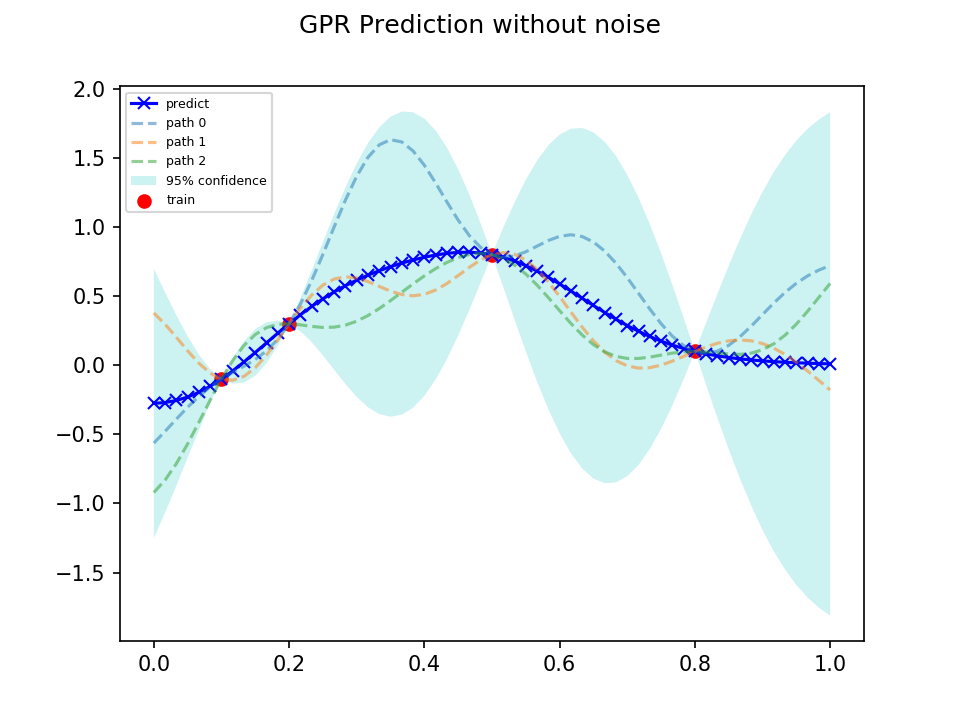

In [8]:
fig_gpr_pred, ax_gpr_pred = plt.subplots()
fig_gpr_pred.suptitle('GPR Prediction without noise')
ax_gpr_pred.scatter(x_train, y_train, marker='o', label='train', c='r')
ax_gpr_pred.plot(x_pred, y_pred, marker='x', label='predict', c='b')
ax_gpr_pred.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_pred - 1.96 * y_var,
                        (y_pred + 1.96 * y_var)[::-1]]), label='95% confidence', 
                 alpha=.2, fc='c', ec='None' )
for i in range(num_paths):
    ax_gpr_pred.plot(x_pred, fs[i], label='path %i' % i, linestyle='--', alpha=0.5)
ax_gpr_pred.legend(loc='upper left', prop={'size': 6})
plt.show()

**Remarks:**
* We see that the prediction exactly interpolates the input data points. That is because we are considering the noise-free case.
* We can see how the paths mostly traverse the inner regions of the $95\%$ confidence zone.
* Unlike for linear regression, we now have a clear picture of uncertainty between the data points and also how quickly uncertainty grows if one extrapolates.

### Noisy Case

Now we consider the same example as above, but we add some noise to the observations.

In [9]:
sigma = 0.4
y_train += np.random.normal(0, sigma, size=y_train.shape)
y_pred, y_cov = gpr_pred(x_train, y_train, x_pred, lambda x, y : np.exp(-(x-y)**2/0.04), sigma)
y_var = np.sqrt(np.maximum(np.asarray(y_cov).diagonal(), 0))

np.random.seed(2)
num_paths=3
fs = np.random.multivariate_normal(mean=y_pred, cov=y_cov, size=num_paths)  

<IPython.core.display.Javascript object>


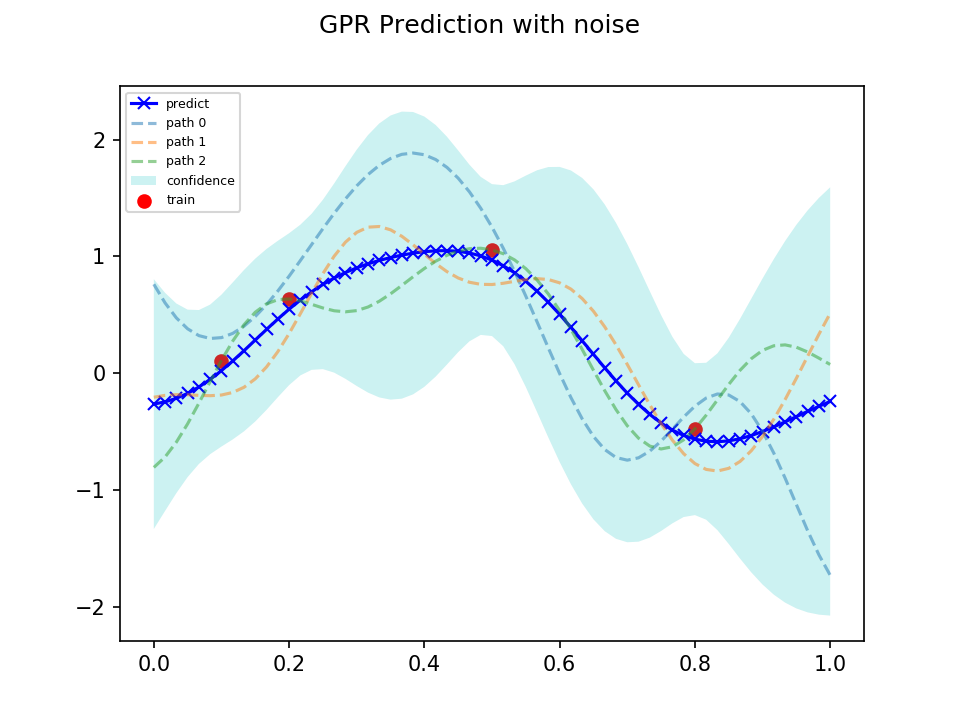

In [10]:
fig_gpr_pred_noise, ax_gpr_pred_noise = plt.subplots()
fig_gpr_pred_noise.suptitle('GPR Prediction with noise')
ax_gpr_pred_noise.scatter(x_train, y_train, marker='o', label='train', c='r')
ax_gpr_pred_noise.plot(x_pred, y_pred, marker='x', label='predict', c='b')
ax_gpr_pred_noise.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_pred - 1.96 * y_var,
                        (y_pred + 1.96 * y_var)[::-1]]), label='confidence', 
                 alpha=.2, fc='c', ec='None' )
for i in range(num_paths):
    ax_gpr_pred_noise.plot(x_pred, fs[i], label='path %i' % i, linestyle='--', alpha=0.5)
ax_gpr_pred_noise.legend(loc='upper left', prop={'size': 6})
plt.show()

**Remarks:**
* Due to the noise the prediction no longer interpolates the input data points. Instead, even at those points we now have a non-trivial confidence region.
* However, the confidence region is still smaller around the input data point than at the point between or beyond them.

# Hyperparameter Optimization
<a id='sect_hyperparameter_optimization'></a>

In the above example, we have used the kernel
\begin{align*}
    k(x,x') := c^2 \exp(-\tfrac{1}{2 \ell^2}|x-x'|^2),
\end{align*}
for some $c, \ell \in \mathbb{R}$. The function $k$ is called the *exponential kernel*, $\ell$ is called the *length scale* and $c$ is called the *signal variance*. We also used the *noise variance* $\sigma^2$. Thus, by using these our predictions depend on the three *hyperparameters* $(\sigma, c, \ell)$ and we have assumed that these are known in advance. While this is useful to derive the theory and quickly look into examples, this assumption is unrealistic. In most practical cases, these parameters will not be known and thus have to be determined. Before we delve into the method of doing this, let us first study the impact of these parameters on the prediction.

## Example: Impact of Hyperparameters

<IPython.core.display.Javascript object>


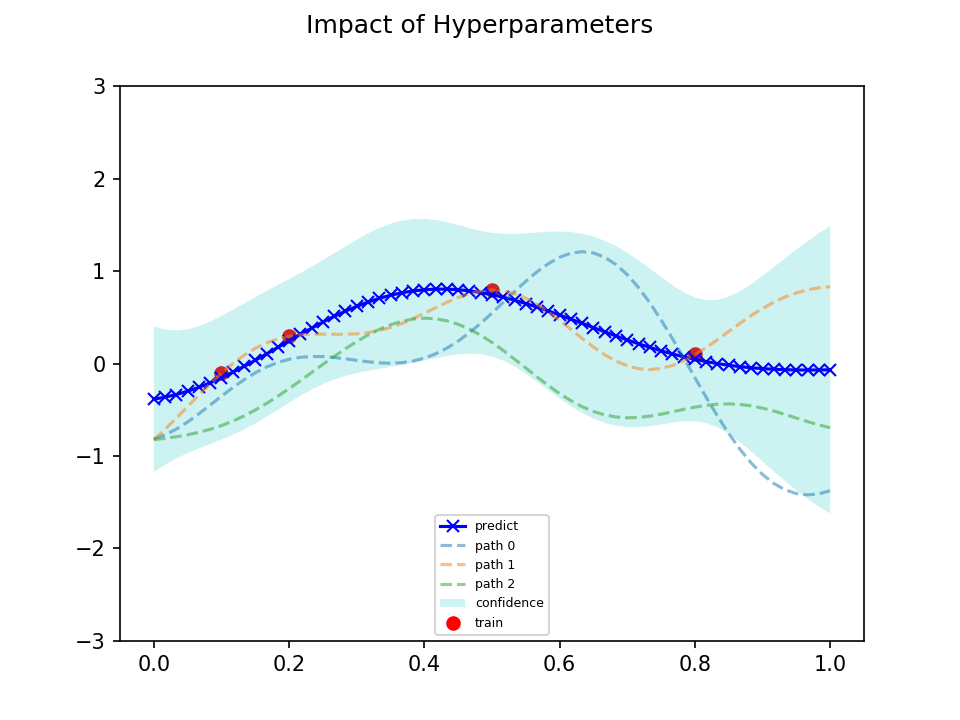

interactive(children=(FloatSlider(value=0.4, description='sigma', max=1.0), FloatSlider(value=1.0, description…

In [11]:
fig_hyp, ax_hyp = plt.subplots()
fig_hyp.suptitle('Impact of Hyperparameters')

x_train = np.array([0.1, 0.2, 0.5, 0.8])
y_train = np.array([-0.1, 0.3, 0.8, 0.1])
M = 61
x_pred = np.linspace(0, 1, M)

@wdg.interact(sigma=wdg.FloatSlider(min=0., max=1, value=0.4, steps=10),
             c=wdg.FloatSlider(min=1, max=5, value=1, steps=10),
             l=wdg.FloatSlider(min=0.01, max=1, value=0.2, steps=10))
def plot_prediction(sigma, c, l):

    cov_fun = lambda x, y : c**2 * np.exp(-(x-y)**2/(2 * l**2))
    np.random.seed(1)
    y_train_noisy = y_train + np.random.normal(0, sigma, size=y_train.shape)
    y_pred, y_cov = gpr_pred(x_train, y_train, x_pred, cov_fun, sigma)
    y_var = np.sqrt(np.maximum(np.asarray(y_cov).diagonal(),0))
    num_paths=3
    fs = np.random.multivariate_normal(mean=y_pred, cov=y_cov, size=num_paths)  

    ax_hyp.clear()
    ax_hyp.scatter(x_train, y_train, marker='o', label='train', c='r')
    ax_hyp.plot(x_pred, y_pred, marker='x', label='predict', c='b')
    ax_hyp.fill(np.concatenate([x_pred, x_pred[::-1]]),
             np.concatenate([y_pred - 1.96 * y_var,
                            (y_pred + 1.96 * y_var)[::-1]]), label='confidence', 
                     alpha=.2, fc='c', ec='None' )
    for i in range(num_paths):
        ax_hyp.plot(x_pred, fs[i], label='path %i' % i, linestyle='--', alpha=0.5)
    ax_hyp.legend(loc='lower center', prop={'size': 6})
    ax_hyp.set_ylim([-3, 3])
    plt.show()

## Optimize via Marginal Log-Likelihood

For any continuous random variable, its *log-likelihood* function is simply the logarithm of its density. Thus, for GPR we can consider the variable $Y = F(X) + \varepsilon$ from the predictive distribution theorem above. This random variable is Gaussian with zero mean and covariance matrix $K(X,X) + \sigma^2 I $. Notice that the hyperparameters $c, \ell$ are implicit in the $K$. As the density $p(y)$ of a multivariate Gaussian $Y$ is well known, the log-likelihood of $Y$ is given by
\begin{align*}
    L(y;\sigma, c, \ell)
    = \log(p(y; \sigma, c, \ell)) 
    = - \frac{1}{2} ( \log(\det(K(X,X) + \sigma^2 I) - y^{\top}(K(X,X) + \sigma^2 I)^{-1}) y + N \log(2 \pi)).
\end{align*}

One typical method of chosing the hyperparameters $(\sigma, c, \ell)$ is to maximize the log-marginal likelihood at the training data $y$. This is a multivariate non-linear optimization problem, hence, one should use a library function for that, see [tech stack choices](#sect_tech_stack).

# Covariance Kernels

One should highlight that not only the parameters of the kernel $k$, but also the kernel function $k$ itself is a matter of choice and various alternatives are popular. Most of those are readily available in standard libraries. Notice that kernels can also be combined.

## Squared Exponential Kernel (SE)
The *squared exponential kernel* (SE) is the one we have already been using, i.e.
\begin{align*}
    k(x,x') = c^2 \exp(-\tfrac{\|x-x'\|^2}{2 \ell}),
\end{align*}
where $c$ is the signal variance and $\ell$ is the length scale.


## Automatic Relevance Determination Squared Exponential (ARDSE)
This kernel is a slight refinement of the SE kernel and defined by
\begin{align*}
    k(x, x') = c^2 \exp\Big( - \frac{1}{2} \sum_{i=1}^{d}{\Big( \frac{x_i - x'_i}{\ell_i} \Big)} \Big),
\end{align*}
where $c$ is still the* signal variance* the $\ell_i$ are celled *individual (characteristic) length scales*.

## Matérn Class

The *Matérn class* is defined by
\begin{align*}
    k(x,x') = c^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \Big( \frac{\sqrt{2 \nu} \|x-x'\|^2}{\ell} \Big) K(\nu) \Big( \frac{\sqrt{2 \nu} \|x-x'\|^2}{\ell} \Big),
\end{align*}
where $\Gamma$ is [Euler's Gamma function](https://en.wikipedia.org/wiki/Gamma_function) and $K_\nu$ is the [modified Bessel function](https://en.wikipedia.org/wiki/Bessel_function#Modified_Bessel_functions:_Iα,_Kα).

# Tech Stack
<a id='sect_tech_stack'></a>

The toy implementation used in the examples is not recommended for production use. For bigger problem instances it is advisable to use a library that handles the data, the kernel functions and the numerical tasks such as hyperparameter optimization. We present the two very common libraries [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html) and [GPy](https://sheffieldml.github.io/GPy/) and re-compute the above examples with these libraries.

In [13]:
# example data
x_train = np.array([0.1, 0.2, 0.5, 0.8])
y_train = np.array([-0.1, 0.3, 1.8, 0.1])
np.random.seed(1)
y_train_noisy = y_train + np.random.normal(0, sigma, size=y_train.shape)
M = 61
x_pred = np.linspace(0, 1, M)

## GPy

In [14]:
import GPy

In [15]:
# specify the desired kernel
kernel_gpy = GPy.kern.RBF(input_dim=1)

# instantiate the GPR class with training data
# (all data must be of format (num_samples, num_dimensions))
gpy = GPy.models.GPRegression(np.atleast_2d(x_train).T,
                              np.atleast_2d(y_train_noisy).T,
                              kernel_gpy)

# fit the data
#gpy.optimize(messages=True)  # this performs only one restart of the optimizer
gpy.optimize_restarts(num_restarts = 10)  # often better to perform multiple

# perform the prediction
y_pred_mean_gpy, y_pred_cov_gpy = gpy.predict(np.atleast_2d(x_pred).T, full_cov=True)
y_pred_mean_gpy = y_pred_mean_gpy.squeeze()
y_pred_std_gpy = np.sqrt(y_pred_cov_gpy.diagonal()).squeeze()

Optimization restart 1/10, f = 5.047986574363724
Optimization restart 2/10, f = 4.92214006226174
Optimization restart 3/10, f = 5.047986828828963
Optimization restart 4/10, f = 4.922134776292944
Optimization restart 5/10, f = 5.047986597397468
Optimization restart 6/10, f = 4.922134768704536
Optimization restart 7/10, f = 4.922135309524814
Optimization restart 8/10, f = 5.047986793712312
Optimization restart 9/10, f = 5.047986585252078
Optimization restart 10/10, f = 5.04798663150114


In [16]:
gpy # let's take a look at the result

GP_regression.,value,constraints,priors
rbf.variance,0.7846753171664994,+ve,
rbf.lengthscale,0.10664893213350811,+ve,
Gaussian_noise.variance,3.009352837717333e-08,+ve,


In [17]:
# notice how GPy has optimized all 3 parameters including the noise

<IPython.core.display.Javascript object>


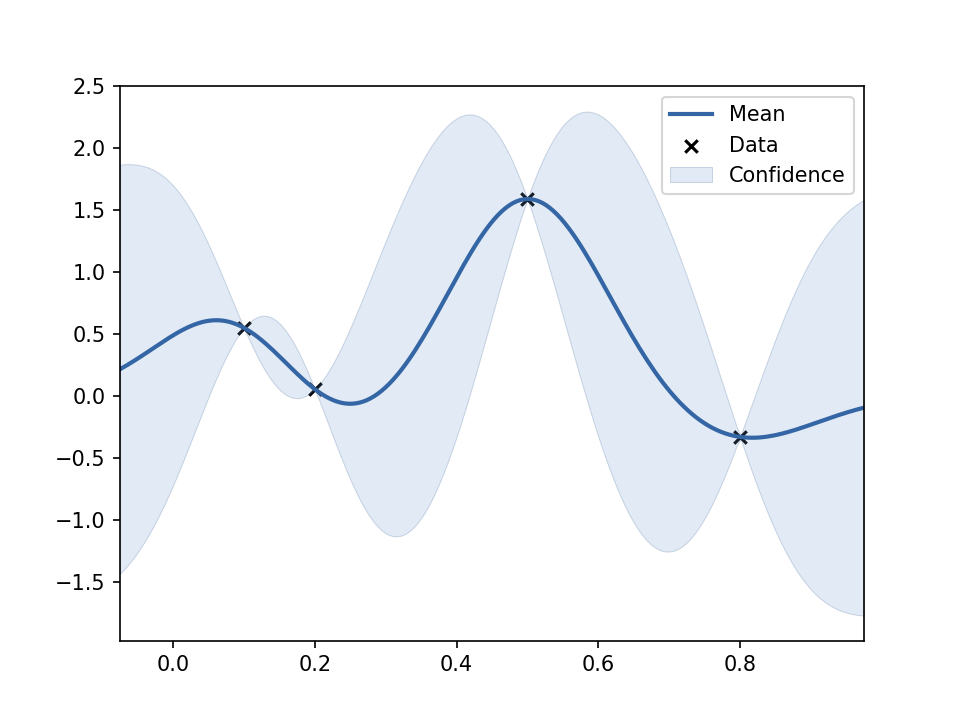

In [18]:
fig_gpy, ax_gpy = plt.subplots()
gpy.plot(ax=ax_gpy) # very easy plotting of results
plt.show()

In [19]:
gpy.to_dict() # transforms all the relevant data of the model into a dict

{'name': 'GP regression',
 'class': 'GPy.models.GPRegression',
 'X': [[0.1], [0.2], [0.5], [0.8]],
 'Y': [[0.5497381454652968],
  [0.055297434539969825],
  [1.5887312990946176],
  [-0.3291874488624682]],
 'kernel': {'input_dim': 1,
  'active_dims': [0],
  'name': 'rbf',
  'useGPU': False,
  'variance': [0.7846753171664994],
  'lengthscale': [0.10664893213350811],
  'ARD': False,
  'class': 'GPy.kern.RBF',
  'inv_l': False},
 'likelihood': {'name': 'Gaussian_noise',
  'gp_link_dict': {'class': 'GPy.likelihoods.link_functions.Identity'},
  'class': 'GPy.likelihoods.Gaussian',
  'variance': [3.009352837717333e-08]},
 'inference_method': {'class': 'GPy.inference.latent_function_inference.exact_gaussian_inference.ExactGaussianInference'}}

In [20]:
noise_var_gpy = gpy.to_dict()['likelihood']['variance'][0] # save for later
signal_var_gpy = gpy.to_dict()['kernel']['variance'][0]
lengthscale_gpy = gpy.to_dict()['kernel']['lengthscale'][0]

In [21]:
noise_var_gpy, signal_var_gpy, lengthscale_gpy

(3.009352837717333e-08, 0.7846753171664994, 0.10664893213350811)

## scikit-learn

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [23]:
# specify kernel with initial parameters and the bounds within to optimize
kernel = ConstantKernel() * RBF()

# instantiate the GPR with pre-specified noise parameter alpha
# (we use the noise (alpha parameter) from GPy here for comparison but of course any value is possible)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise_var_gpy, n_restarts_optimizer=50)

# fit the GPR to the data
# (this class assumes that all arrays are of the format (num_samples, num_dimensions))
gpr.fit(np.atleast_2d(x_train).T, np.atleast_2d(y_train_noisy).T)

# run the prediction
y_pred_mean_sk, y_pred_std_sk = gpr.predict(np.atleast_2d(x_pred).T, return_std=True)
y_pred_mean_sk = y_pred_mean_sk.squeeze()  # for univariate data the second dimension is spurious
y_pred_std = y_pred_std_sk.squeeze()

In [24]:
gpr.kernel_.get_params()

{'k1': 0.886**2,
 'k2': RBF(length_scale=0.107),
 'k1__constant_value': 0.7846749475148752,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 0.10664884328209365,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

In [25]:
signal_var_sk = gpr.kernel_.get_params()['k1__constant_value']
lengthscale_sk = gpr.kernel_.get_params()['k2__length_scale']

<IPython.core.display.Javascript object>


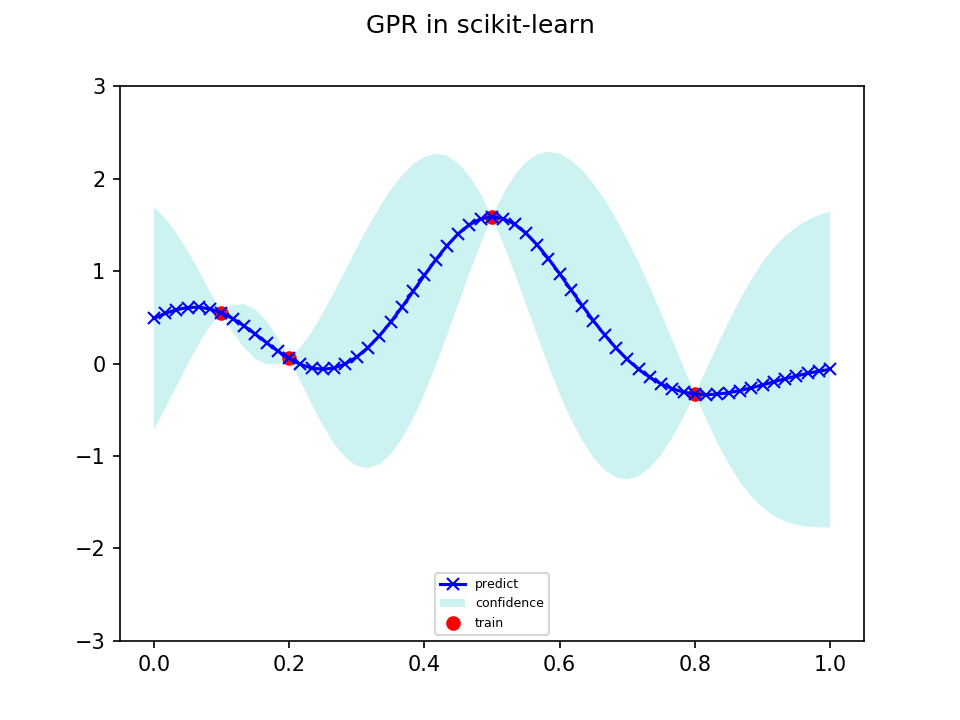

In [26]:
fig_gpr, ax_gpr = plt.subplots()
fig_gpr.suptitle('GPR in scikit-learn')
ax_gpr.scatter(x_train, y_train_noisy, marker='o', label='train', c='r')
ax_gpr.plot(x_pred, y_pred_mean_sk, marker='x', label='predict', c='b')
ax_gpr.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_pred_mean_sk - 1.96 * y_pred_std_sk,
                        (y_pred_mean_sk + 1.96 * y_pred_std_sk)[::-1]]), label='confidence', 
                 alpha=.2, fc='c', ec='None' )

ax_gpr.legend(loc='lower center', prop={'size': 6})
ax_gpr.set_ylim([-3, 3])
plt.show()

## Sanity Check

The GPy and the scikit-learn implementations should give the same result as the ad-hoc implementation from the earlier example. We validate that this is the case.

In [27]:
cov_fun = lambda x, y : signal_var_sk * np.exp(-(x-y)**2/(2 * lengthscale_sk**2))
y_pred_mean_adh, y_pred_cov_adh = gpr_pred(x_train, y_train_noisy, x_pred, cov_fun, np.sqrt(noise_var_gpy))
y_pred_std_adh = np.sqrt(np.maximum(np.asarray(y_pred_cov_adh).diagonal(),0))

<IPython.core.display.Javascript object>


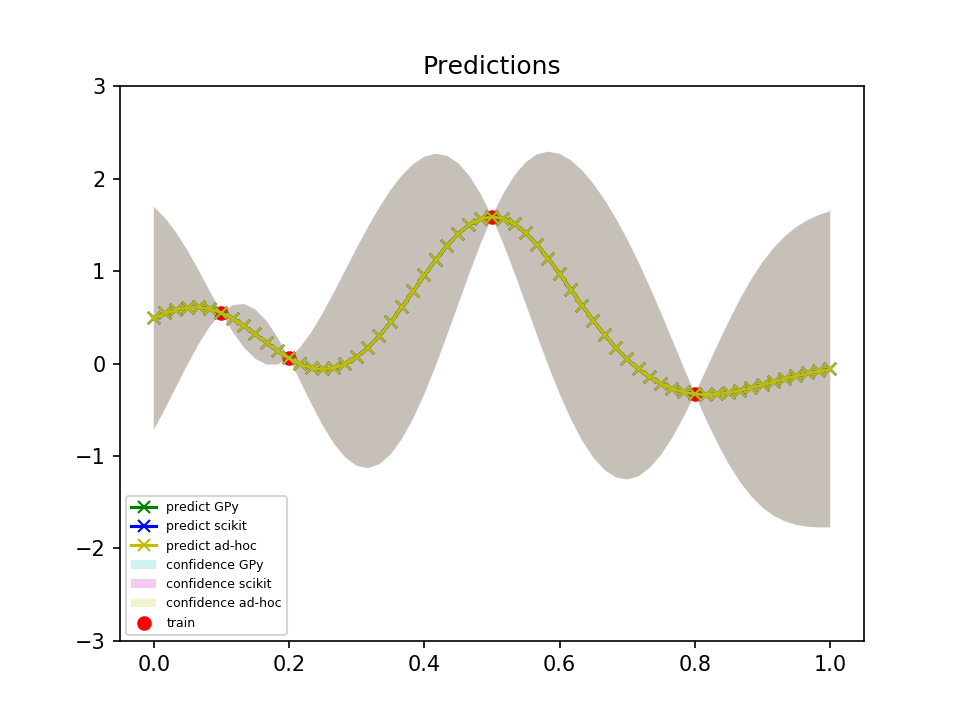

In [28]:
fig_check, ax_check = plt.subplots()

ax_check.set_title('Predictions')
ax_check.scatter(x_train, y_train_noisy, marker='o', label='train', c='r')
ax_check.plot(x_pred, y_pred_mean_gpy, marker='x', label='predict GPy', c='g')
ax_check.plot(x_pred, y_pred_mean_sk, marker='x', label='predict scikit', c='b')
ax_check.plot(x_pred, y_pred_mean_adh, marker='x', label='predict ad-hoc', c='y')
ax_check.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_pred_mean_gpy - 1.96 * y_pred_std_gpy,
                        (y_pred_mean_gpy + 1.96 * y_pred_std_gpy)[::-1]]), label='confidence GPy',
                 alpha=.2, fc='c', ec='None' )
ax_check.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_pred_mean_sk - 1.96 * y_pred_std_sk,
                        (y_pred_mean_sk + 1.96 * y_pred_std_sk)[::-1]]), label='confidence scikit',
                 alpha=.2, fc='m', ec='None' )
ax_check.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_pred_mean_adh - 1.96 * y_pred_std_adh,
                        (y_pred_mean_adh + 1.96 * y_pred_std_adh)[::-1]]), label='confidence ad-hoc',
                 alpha=.2, fc='y', ec='None' )
ax_check.legend(loc='lower left', prop={'size': 6})
ax_check.set_ylim([-3, 3])
plt.show()

As we can see, all the predictions and confidence bounds of the three methods agree.

# Appendix A: GPR as a Bayesian View of Linear Regression
<a id='lr_vs_gpr'></a>
The setup of Gaussian process regression is similar to that of linear regression. In fact, one can show that a Bayesian view of linear regression is equivalent to Gaussian process regression with a bilinear kernel. We derive the details in the following section.

## Reminder of Linear Regression (LR)

In linear regression, the labelled input data set is the same as in GPR, i.e. we are given $x_i \in \mathbb{R}^d$, $y_i \in \mathbb{R}$, $i=1, \ldots, N$. 

**Feature Extraction:** We usually do not work on the $x_i$ directly, but first extract some features via a *feature map* $\phi:\mathbb{R}^{d} \to \mathbb{R}^m$, for example the popular *polynomial features map of degree $m-1$:
\begin{align*}
    x \mapsto \begin{pmatrix}
        1 & x & x^2 \ldots & x^m
    \end{pmatrix}^{\top}.
\end{align*}

**Linear Hypothesis:** We want to fit a linear hypothesis 
\begin{align*}
    f=f_{\beta}:\mathbb{R}^d \to \mathbb{R}, \quad
    x \mapsto \phi(x)^{\top} \beta
\end{align*}
to that data by finding an optimal $\beta \in \mathbb{R}^m$.

**Assumtions:** We assume that for any $i=1, \ldots, N$,
\begin{align*}
    y_i = f_{\beta}(x_i) + \varepsilon_i,
\end{align*}
where $\varepsilon_i$ are realizations of an iid random variable $\varepsilon$ with zero mean called *noise*. 

**Cost Functional:** The problem of finding $\beta$ is typically achieved by solving the *least squares problem*
\begin{align*}
    \hat \beta = \operatorname{argmin}_{\beta}{\sum_{i=1}^{N}{(f_{\beta}(x_i)-y_i)^2}}.
\end{align*}

**Design Matrix:** To solve the least squares problem, we collect all the inputs in the *design matrix* (written as column matrix)
\begin{align*}
    Phi(X) := \begin{pmatrix}
       \varphi(x_1) &
        \ldots &
        \varphi(x_N)
    \end{pmatrix} \in \mathbb{R}^{m \times N}
\end{align*}

**Normal Equations:** The solution $\hat \beta $ to the least squares problem is given by the *normal equation*
\begin{align*}
     \hat \beta = (\Phi(X) \Phi(X)^{\top})^{-1} \Phi y \in \mathbb{R}^{m}
\end{align*}
under the assumption that $\Phi \Phi^{\top} \in \mathbb{R}^{m \times m}$ is invertible. For practical applications with $N \gg m$, this is typically the case.

**Predictions:** We can then make predictions on new data $x^* \in \mathbb{R}^m$ via 
\begin{align*}
    f_{\hat \beta}(x^*) = \phi(x^*)^{\top} \beta \in \mathbb{R}    
\end{align*}
In case of multiple predictions, we can collect them in a matrix $X^* \in \mathbb{R}^{m \times l}$ and apply the predictor $f_{\hat \beta}$ to every component resulting in
\begin{align*}
    F(X^*) := \Phi(X^*)^{\top} \hat \beta = \Phi(X^*)^{\top} (\Phi(X) \Phi(X)^{\top})^{-1} \Phi(X) y \in \mathbb{R}^l
\end{align*}

## Bayesian View of Linear Regression

### Setup

**Model Assumptions:** For the Bayesian view of linear regression, let
* $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space
* $\mathscr{x}_i$ be $\mathbb{R}^d$-valued iid random variables
* $\varepsilon_i$ are $\mathbb{R}$-valued iid and Gaussian, i.e. $\varepsilon_i \sim \mathcal{N}(0, \sigma^2)$
* $b$ is an $\mathbb{R}^m$-valued random variable
* $\mathscr{x}_i$ and $\varepsilon_i$ are independent, $i=1, \ldots, N$
* $\mathscr{y}_i = \Phi(\mathscr{x})^{\top}_i \beta + \varepsilon_i$.

We set $\mathscr{Y} = (\mathscr{y}_1, \ldots, \mathscr{y}_N)$, $\mathscr{X}=(\mathscr{x}_1, \ldots, \mathscr{x}_N)$ and $\varepsilon = (\varepsilon_1, \ldots, \varepsilon_N)$, thus we can write
\begin{align*}
    \mathscr{Y} = \Phi(\mathscr{X})^{\top} b + \varepsilon.
\end{align*}

**Input Data:** We still assume to be given the same input data, i.e.
* $X=(x_1, \ldots, x_N)$, $x_i \in \mathbb{R}^d$,
* $Y=(y_1, \ldots, y_N)$, $y_i \in \mathbb{R}$.

### Predictive Distribution

We now describe how to fit the model to the data. The definitions immediately imply the following.

**Lemma**: The conditional distribution of $\mathscr{Y}$ given $\mathscr{X}=X$ and $b=\beta$ is
\begin{align*}
    \mathcal{Y} \mid \mathcal{X}=X, b=\beta \sim \mathcal{N}(\Phi(X)^{\top} \beta, \sigma^2 I).
\end{align*}

Using Bayes theorem for densities one can prove the following:

**Theorem**: If $b \sim \mathcal{N}(0, \Sigma)$, then
\begin{align*}
    b \mid \mathcal{X}=X, \mathcal{Y}=Y \sim \mathcal{N} (\bar \beta, A^{-1}),
\end{align*}
where
\begin{align*}
    A:= \sigma^{-2} \Phi(X) \Phi(X)^{\top} + \Sigma^{-1} \in \mathbb{R}^{m \times m}, && \bar \beta := \sigma^{-2} A^{-1}\Phi(X) Y \in \mathbb{R}^{m},
\end{align*}
under the assumption that $A$ is invertible.

**Remark**: Notice that $\bar \beta$ is thus given by
\begin{align*}
    \bar \beta = (\Phi(X) \Phi(X)^{\top} + \sigma^2 \Sigma)^{-1} \Phi(X) y,
\end{align*}
which is the same as the $\hat \beta$ in LR above, but with the $\sigma^2 \Sigma$ term added.

**Lemma**: Let $\mathscr{x}^*$ be an $\mathbb{R}^d$-valued random variable, $x^* \in \mathbb{R}^d$, and $f(\mathscr{x}^*) := f_{\bar \beta}(\mathscr{x}^*)$. Then
\begin{align*}
    f(\mathscr{x}^*) \mid \mathscr{x}^*=x^*, \mathscr{X}=X, \mathscr{Y}=y \sim \mathcal{N}(\phi(x^*)^{\top} \bar \beta , \phi(x^*)^{\top} A^{-1} \phi(x^*)).
\end{align*}
This is called the *predictive distribution*. 

In case of multiple predictions $X^*$, which are $\mathbb{R}^{d \times l}$-valued, we obtain analogously 
\begin{align*}
    F(\mathscr{X}^*) \mid \mathscr{X}^* = X^*, \mathscr{X}=X, \mathscr{Y}=Y] \sim \mathcal{N}(\Phi(X^*)^{\top} \bar \beta , \Phi(X^*)^{\top} A^{-1} \Phi(X^*).
\end{align*}

The predictions then are made by taking the mean of the predictive distribution.

### Bilinear Kernel Function
One can re-write the mean and the variance of the predictive distribution via the *kernel function*
\begin{align*}
    k:\mathbb{R}^{m} \times \mathbb{R}^m \to \mathbb{R}, &&
    (x, x') \mapsto \phi(x)^{\intercal} \Sigma \phi(x')
\end{align*}
and as usual we employ the convention that for any two (column) matrices (of vectors) $V \in \mathbb{R}^{m \times r}$, $W \in \mathbb{R}^{m \times s}$
\begin{align*}
    K(V,W) := (k(v_{i},w_j))_{1 \leq i \leq r, 1 \leq j \leq s} \in \mathbb{R}^{r \times s}
\end{align*}

**Theorem (predictive distribution with bilinear kernel)**: For any $\mathbb{R}^{d \times l}$-valued $\mathscr{X}^*$ and any data $X^* \in \mathbb{R}^{d \times l}$, the following holds: If $K(X,X) + \sigma^2 I \in \mathbb{R}^{N \times N}$ is invertible, then the predictive distribution is given as
\begin{align*}
    F(\mathscr{X}^*) \mid \mathscr{X}^*=X^*, \mathscr{X}=X, \mathscr{Y}=Y \sim \mathcal{N}(m^*, k^*),
\end{align*}
where
\begin{align*}
    m^* &= K(X^*,X) (K(X,X) + \sigma^2 I)^{-1}Y \\
    k^* &= K(X^*,X^*) - K(X^*,X)(K(X,X) + \sigma^2 I)^{-1}K(X,X^*)).
\end{align*}

**Proof**: To see the claim about the mean, notice that
\begin{align*}
    A_{\Phi} \Sigma \Phi(X)
    & = (\sigma^{-2}\Phi(X)\Phi(X)^{\top} + \Sigma^{-1}) \Sigma \Phi(X) \\
    &= \sigma^{-2}(\Phi(X)\Phi(X)^{\top}\Sigma \Phi(X)^{\top} + \sigma^{2} \Phi(X)) \\
    &= \sigma^{-2} \Phi(X) (\Phi(X)^{\top}\Sigma \Phi(X) + \sigma^{2} I) \\
    &= \sigma^{-2} \Phi(X) (K(X,X) + \sigma^{2} I),
\end{align*}
thus
\begin{align*}
    \sigma^{-2} A_{\Phi}^{-1} \Phi(X) & = \Sigma \Phi(X)(K(X,X) + \sigma^{2} I)^{-1} \\
    \Longrightarrow  \bar w_{\Phi} &= \sigma^{-2} A_{\Phi}^{-1} \Phi(X)Y = \Sigma \Phi(X)(K(X,X) + \sigma^{2} I)^{-1}Y \\
    \Longrightarrow  \Phi(X^*)^{\top} \bar w_{\Phi}& = \Phi(X^*)^{\top} \Sigma \Phi(X)(K + \sigma^{2} I)^{-1}Y =  K(X^*,X) (K(X,X) + \sigma^{2} I)^{-1}Y.
\end{align*}
To see the claim about the variance, we apply the matrix inversion lemma (see appendix below) to $Z^{-1} := \Sigma$, $W^{-1} := \sigma^{2} I$, $V := U := \Phi(X)$. This results in 
\begin{align*}
    A^{-1} = (\sigma^{-2} \Phi(X) \Phi(X)^{\top} + \Sigma)^{-1} = \Sigma - \Sigma \Phi(X)(\sigma^{2}I + K(X,X))^{-1} \Phi(X)^{\top} \Sigma,
\end{align*}
which implies the claim.

**Remark (Kernel Trick):**
* Notice that in the above expressions for $m^*$ and $k^*$, we only need to know expressions of the form 
\begin{align}
    \Phi(x)^\top \Sigma_p \Phi(x), && \Phi(x^*)^\top \Sigma_p \Phi(x), && \Phi(x^*)^\top \Sigma_p \Phi(x^*)
\end{align}
to evaluate the kernel $k$ on $X$ and $X^*$.
* Lifting from input space $x$ to feature space $\Phi(x)$ is called the *kernel trick*.

### GPR vs LR
If we compare the predictions $F_*^{\operatorname{LR}}$ made by linear regression LR and $F_*^{\operatorname{GPR}}$ made by Gaussian Process regression with noise $\sigma$, covariance prior $\Sigma:=$, and $\Phi(X)=X$, we obtain
\begin{align*}
    F_*^{\operatorname{LR}} &=  \Phi(X^*)^{\top} (\Phi(X) \Phi(X)^{\top})^{-1} \Phi(X)Y  \\
    F_*^{\operatorname{GPR}} &= \Phi(X^*)^{\top}(\Phi(X)\Phi(X)^{\top} + \sigma^2 I)^{-1} XY = K(X^*,X) (K(X,X) + \sigma^2 I)^{-1}Y \\
    &=\Phi(X^*)^{\top} \Phi(X)(\Phi(X)^{\top}\Phi(X) + \sigma^2 I)^{-1} Y\\
\end{align*}
under the assumption that both $\Phi(X)\Phi(X)^{\top} + \sigma^2 I \in \mathbb{R}^{m \times m}$ and $\Phi(X)^{\top}\Phi(X) + \sigma^2 I \in \mathbb{R}^{N \times N}$ are invertible. As typically, $N \gg m$, $\Phi(X)\Phi(X)^{\top}\in \mathbb{R}^{m \times m}$ is typically invertible and thus $\Phi(X)\Phi(X)^{\top} + \sigma^2 I$ will also be invertible even for $\sigma=0$. The matrix $\Phi(X)^{\top}\Phi(X) \in \mathbb{R}^{N \times N}$ will never be invertible, however, $\Phi(X)^{\top}\Phi(X) + \sigma^2 I \in \mathbb{R}^{N \times N}$ may or may not be invertible depending on $\sigma$. For $\sigma$ large enough it is invertible, but for $\sigma \searrow 0$ it will become singular at some point. The fact that the bilinear kernel without noise can get singular motivates the choice of alternative kernel functions such as the exponential kernel.

One can illustrate this comparison numerically as follows:

<IPython.core.display.Javascript object>


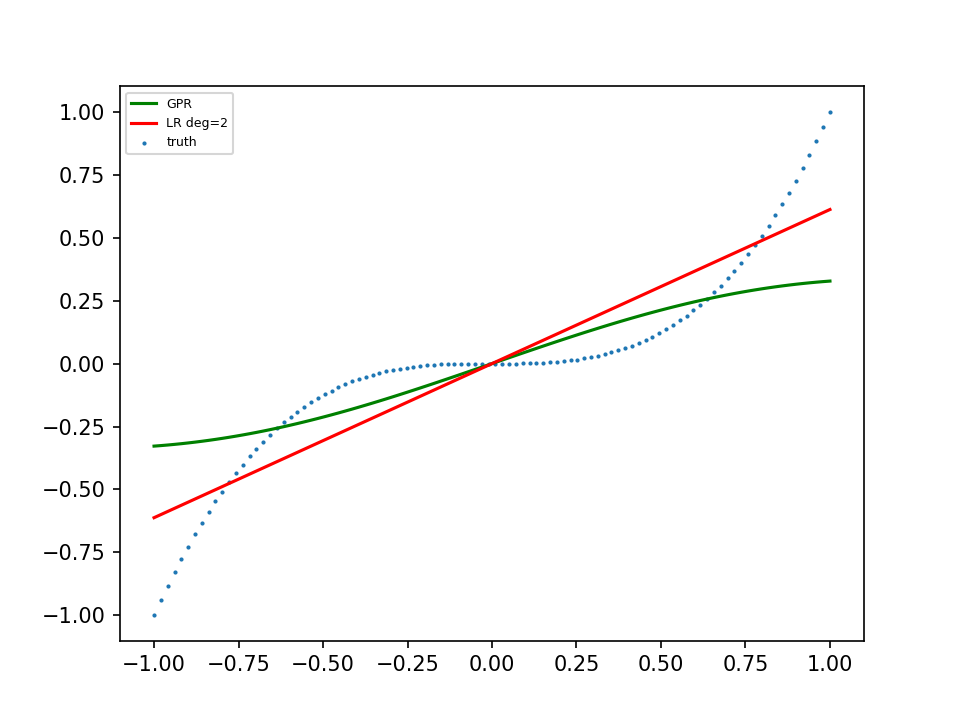

interactive(children=(FloatSlider(value=10.0, description='sigma', max=10.0), Output()), _dom_classes=('widget…

In [29]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots()

@wdg.interact(sigma=wdg.FloatSlider(min=0, max=10, value=10, step=0.1))
def plot_comparison(sigma):
    N = 100
    x = np.linspace(-1,1,N)
    #e = np.random.normal(0, 0.1, N)
    y = x**3
    # GPR
    #kernel = DotProduct(sigma_0=0, sigma_0_bounds='fixed')
    kernel = ConstantKernel(1.0, (1e-3, 1e10)) * RBF(100, (1e-3, 1e10))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma,  n_restarts_optimizer=10)
    gp.fit(np.atleast_2d(x).T, np.atleast_2d(y).T)
    y_pred_gpr, gp_sigma = gp.predict(np.atleast_2d(x).T, return_std=True)
    #LR
    d=2
    poly = PolynomialFeatures(degree=d)
    X_ = poly.fit_transform(np.atleast_2d(x).T)
    reg = LinearRegression()
    reg.fit(X_, np.atleast_2d(y).T)
    y_pred_cv_reg = reg.predict(poly.fit_transform(np.atleast_2d(x).T))
    ax.clear()
    ax.scatter(x, y, marker='o', s=1, label='truth')
    ax.plot(x, y_pred_gpr, label="GPR", color='g')
    ax.plot(x, y_pred_cv_reg, label="LR deg=2", color='r')
    ax.legend(prop={'size': 6})    

# Appendix B: Mathematical Background

## Multivariate Normal Distribution

**Definition (univariate normal)**: A real-valed random variable $X$ is *Gaussian* or *normal* if it has a density $p$ against the Lebesgue measure and there are $\mu, \sigma \in \mathbb{R}$, $\sigma >0$ such that
\begin{align*}
    \forall x \in \mathbb{R}: p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\Big(-\frac{(x-\mu)^2}{2 \sigma^2}\Big)
\end{align*}
In this case, we write $X \sim \mathcal{N}(\mu, \sigma^2)$. We call $\mu$ the *mean* and $\sigma^2$ the *variance*. 
In case $\mathbb{P}[X=\mu]=1$, we also write $X \sim \mathcal{N}(\mu, 0)$.

**Definition (multivariate normal)**: An $\mathbb{R}^d$-valued random variable $X$ is *Gaussian* if there exists $\mu \in \mathbb{R}^d$ and a positive semi-definite $\Sigma \in \mathbb{R}^{d \times d}$ such that
\begin{align*}
    \forall v \in \mathbb{R}^d: v^{\intercal} X \sim \mathcal{N}(v^{\intercal} \mu, v^{\intercal} \Sigma v)
\end{align*}
In this case, we write $X \sim \mathcal{N}(\mu, \Sigma)$ and $\mu$ is called the *mean vector* and $\Sigma$ is called the *covariance matrix*.

Notice that this implies that the components $X_i \sim \mathcal{N}(\mu_i, \Sigma_{ii})$ and $\operatorname{Cov}[X_i, X_j] = \Sigma_{ij}$. Conversely, if $X_1, \ldots, X_d$ are independent and $X_i \sim \mathcal{N}(\mu_i, \sigma_i^2)$, then $X=(X_1, \ldots, X_d) \sim \mathcal{N}(\mu, \operatorname{diag}(\sigma_i^2))$ .

**Lemma (density)**: If $X$ is multivariate Gaussian and $\Sigma$ is positive definite, then $X$ has a density satisfying
\begin{align*}
    \forall x \in \mathbb{R}^d: p(x) = (2 \pi)^{-\tfrac{d}{2}} \det(\Sigma)^{-\tfrac{1}{2}} \exp(-\tfrac{1}{2}(x-\mu)^{\intercal} \Sigma^{-1}(x-\mu))
\end{align*}
The matrix $K := \Sigma^{-1}$ is called the *concentration* of the distribution.

**Lemma (linear transformations)**: Let $X \in \mathcal{N}(\mu, \Sigma)$ of dimension $d$ and $A \in \mathbb{R}^{r \times d}$ and $b \in \mathbb{R}^r$. Then $Y := AX + b \in \mathcal{N}(A \mu + b, A \Sigma A^{\intercal})$ of dimension $r$.

<a id='lem_cond_part_gaussian'></a>
**Theorem (partition and condition):** Let $X=(X_1, X_2)$, where $X_i$ are $\mathbb{R}^{d_i}$-valued. If $X \sim \mathcal{N}(\mu, \Sigma)$ of dimension $d:=d_1 + d_2$, then $X_i \sim \mathcal{N}(\mu_i, \Sigma_{ii})$ of dimension $d_i$, where
\begin{align*}
    \mu = \begin{pmatrix}
        \mu_1 \\
        \mu_2
    \end{pmatrix}, 
    && \Sigma = \begin{pmatrix}
        \Sigma_{11} & \Sigma_{12} \\
        \Sigma_{21} & \Sigma_{22}
    \end{pmatrix} 
\end{align*}
with $\mu_i \in \mathbb{R}^{d_i}$, $\Sigma_{ii} \in \mathbb{R}^{d_i \times d_i}$, $i=1,2$. 

In case $\Sigma_{22}$ is regular, then the conditional distribution of $X_1$ given $X_2=x_2$ satisfies
\begin{align*}
    \forall x_2 \in \mathbb{R}^{d_2}: X_1 \mid X_2=x_2 \sim \mathcal{N}(\mu_{1 \mid 2}, \Sigma_{1 \mid 2}),
\end{align*}
where
\begin{align*}
    \mu_{1 \mid 2} := \mu_1 + \Sigma_{12} \Sigma_{22}^{-1}(x_2 - \mu_2), && \Sigma_{1 \mid 2} := \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21}.
\end{align*}

## Matrix Inversion Lemma

**Lemma**: Let $Z \in \mathbb{R}^{n \times n}$, $W \in \mathbb{R}^{m \times m}$, $U,V \in \mathbb{R}^{n \times m}$. If $Z$, $W$ and $Z+UWV^{\top}$ are invertible, then
\begin{align*}
    (Z+ UWV^{\top})^{-1}
    &= Z^{-1} + Z^{-1} U (W^{-1} + V^{\top} Z^{-1} U) V^{\top} Z^{-1}
\end{align*}